find `C_f` and `P_f`
Todo: 
1. if oo is a critical point of f and f is not a polynomial, conjugate f by some mobius transformation
2. if f is conjugate to a polynomial, redefine f as the polynomial
3. check if the number of preimage about a critical point match the multiplicity
4. Optional: warn if we’re near a critical value
```
#near_crit = []
#for z in matched:
#    fp = _deriv_f_at(P, Q, z)
#    if fp != CC.infinity() and abs(fp) < warn_crit:
#        near_crit.append((z, abs(fp)))
#if near_crit:
#    print(f"[note @ step {idx}] {len(near_crit)} preimage(s) near a critical point (|f'|< {warn_crit}). "
#          f"Local inverse branches may merge/split: {near_crit}")
```
5. test `_path_from_a2b`
6. try to use function from arithmetic_dynamics package


True
1
0
1
True


AttributeError: 'list' object has no attribute 'replace'

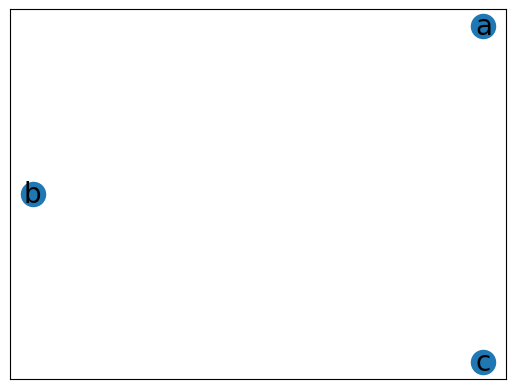

In [77]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools as it
import numpy as np
import logging

class Automaton:
    def __init__(self):
        self.state = set()
        self.symbol = set()
        # Dictionary to store edges: {(source, symbol): (target, output)}
        self.edge = {}

    def add_vertex(self, vertex):
        self.state.add(vertex)

    def add_edge(self, source, symbol, target, output):
        if (source, symbol) in self.edge:
            logging.error(f"Warning: Edge for state '{source}' and symbol '{symbol}' already exists. Conflict of relations!")
            # You can raise an exception here instead if you want to completely stop execution
            # raise ValueError(f"Edge for state '{source}' and symbol '{symbol}' already exists.")
            return  # Stop further execution of this method
        self.edge[(source, symbol)] = (target, output)
        self.symbol.add(symbol)
        self.symbol.add(output)

    def graph(self):
        graph = nx.MultiDiGraph()  # Use MultiDiGraph for potential parallel edges
        graph.add_nodes_from(self.state)
        for (source, symbol), (target, output) in self.edge.items():
            graph.add_edge(source, target, label=f"({symbol},{output})")

        draw_labeled_multigraph(graph, "label")  # Call draw_labeled_multigraph

    def from_string_list(self, string_list):
        for edge_string in string_list:
            source_state = edge_string.split("=")[0].split(".")[0]
            source_symbol = edge_string.split("=")[0].split(".")[1]

            target_symbol = edge_string.split("=")[1].split(".")[0]
            target_state = edge_string.split("=")[1].split(".")[1]

            self.add_vertex(source_state)
            self.add_vertex(target_state)
            self.add_edge(source_state, source_symbol, target_state, target_symbol)

        assert self.is_valid() == True

    def is_valid(self):
        if len(self.state) * len(self.symbol) != len(self.edge):
          logging.warning(f"The cardinality of domain of transition function should be '{len(self.state) * len(self.symbol)}', but we only found '{len(self.edge)}'")
          return False

        return True  # Automaton is valid

    def is_invertible(self):
      output_symbol_by_state = dict()
      for (source_state, source_symbol), (target_state, target_symbol) in self.edge:
        output_symbol_by_state[source_state].add(target_symbol)

      for state in self.state:
        if len(output_symbol_by_state[state]) != len(self.symbol):
          logging.warning(f"The number of output symbols for state '{state}' is '{len(output_symbol_by_state[state])}', but '{len(self.symbol)}' expected.")
          return False

      return True


    def is_irreducible(self):
      """ Check if an automaton has equivalent states"""

      '''
      1: different initially
      0: different later
      -1: unvisited
      -2: same
      '''
      def DFS(source, affect, diff):
        if source not in affect:
          return

        for target in affect[source]:
          assert diff[target] != -2

          ''' visit only unvisited vertices'''
          if diff[target] < 0:
            diff[target] = 0

            DFS(target, affect, diff)

      ''' Whether two states are different '''
      diff = dict()

      ''' The set of pair of states that are different because this pair of states are different '''
      affect = dict()

      ''' set up edge and status '''
      for s1 in self.state:
        for s2 in self.state:
          if s2 > s1:
            diff[(s1, s2)] = -1

            ''' Whether no different output symbols are observed for these two states '''
            good = True
            for symbol in self.symbol:
              if self.edge[(s1, symbol)][1] != self.edge[(s2, symbol)][1]:
                good = False
                break

            if good != True:
              diff[(s1, s2)] = 1
            else:
              for symbol in self.symbol:
                ns1 = self.edge[(s1, symbol)][0]
                ns2 = self.edge[(s2, symbol)][0]

                nt1 = min(ns1, ns2)
                nt2 = max(ns1, ns2)

                if nt1 == nt2:
                  continue

                good = False

                ''' if nt1 and nt2 are not equivalent, then nor are s1 and s2 '''
                if (nt1, nt2) not in affect:
                  affect[(nt1, nt2)] = set()

                affect[(nt1, nt2)].add((s1, s2))

              if good == True:
                ''' same '''
                diff[(s1, s2)] = -2


      for s1 in self.state:
        for s2 in self.state:
          ''' We only start from pairs of different states that we initially know are different '''
          if s1 < s2 and diff[(s1, s2)] == 1:
            DFS((s1, s2), affect, diff)

      num_same_pair = (len(self.state) * (len(self.state) - 1)) // 2
      for s1 in self.state:
        for s2 in self.state:
          if s1 < s2:
            print(diff[(s1, s2)])

            assert diff[(s1, s2)] == -2 or diff[(s1, s2)] == 0 or diff[(s1, s2)] == 1
            if diff[(s1, s2)] >= 0:
              num_same_pair -= 1
            else:
              print(f"same states: ({s1}, {s2})")

      return num_same_pair == 0


def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attrs[attr_name]}"  # Get edge label from 'label' attribute
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )
    plt.show() # Show plot after drawing

# Example usage:
automaton = Automaton()
string_list = ['a.0=1.b', 'a.1=0.c', 'b.0=1.c', 'b.1=0.a','c.0=0.c','c.1=1.c']
automaton.from_string_list(string_list)
print(automaton.is_valid())
print(automaton.is_irreducible())
automaton.graph()

In [519]:
x = var('x')
f = -4*x^3 + 6*x^2 - 1/2
base_point = i+1
steps = 10

In [100]:
# draw graphs
figure_dict = {}
for critical_point in P_f:
    base_point_path = [base_point - (n/steps)*(base_point - critical_point) for n in range(steps)]
    preimages_set = [[sol[x] for sol in solve(f==p, x, solution_dict=True)] for p in base_point_path]
    G = sum(list_plot(point_list+list(P_f), hue=k/10) for k, point_list in enumerate(preimages_set))
    figure_dict[critical_point] = G
f_infty = 1/(f(x=1/x)).full_simplify()
base_point_path = [(1-n/100)*(base_point) for n in range(1,100)]
preimages_set = [[sol[x].full_simplify() for sol in solve(f_infty==p, x, solution_dict=True)] for p in base_point_path]
G = sum(list_plot(point_list, hue=k/10) for k, point_list in enumerate(preimages_set))
figure_dict['infty']= G

In [67]:
def homotopy_type(f, base_point, step,):
    import string
    critical_branch_dict, C_f, P_f = find_critical_branch(f, base_point, step)
    labels = list(string.ascii_lowercase)      # ['a', 'b', 'c', ..., 'z']
    P_f = list(P_f)
    pole_dict = {P_f[i]: labels[i] for pole in P_f}
    refine_critical_branch_dict = {pole:[[preimage[0],preimage[-1]] for preimage in critical_branch_dict[pole]] for pole in P_f}
    temp = P_f[0]
    preimages = [preimage for preimage in refine_critical_branch_dict[temp]]
    preimages_copy = preimages
    cp_preimage_dict = dict()
    union_C_P = set(C_f).union(set(P_f))
    for pole in P_f:
        for preimage in refine_critical_branch_dict[pole]:
            if preimage[1] in union_C_P:
                try:
                    cp_preimage_dict[preimage[1]].append(preimage[0])
                except:
                    cp_preimage_dict[preimage[1]] = [preimage[0]]
    for pole in P_f:
        for preimage in refine_critical_branch_dict[pole]:
            if preimage[1] in P_f:
                print(f"{c1}.{i1}={c2}.{i2}", )
            else:
                
                preimages.index(preimage)
                print(f"{c1}.{i1}={c2}.id", pole_dict[pole], , )
        else:
            print(f"{c1}.{i1}={c2}.i")
            
    cp_preimage_dict
    #P_f = critical_branch_dict.keys()
    #
    

SyntaxError: invalid syntax (2553696284.py, line 27)

This is the psudocode to produce relations:
1. def `gen_dict[post_crit_value] -> alphabet`
2. compute `gen_dict[oo]^(-1)` as product of `gen_dict[post_crit_value]`
3. compute `r[i]` as a "sub" product of `gen_dict[post_crit_vale]` (remove some generators)
4. define a helper `phi:gen_dict[post_crit_value] -> gen_dict[post_crit_value]` to compute `phi(r[i]^(-1)*gen_dict[post_crit_value]*r[j])` where `gen_dict[post_crit_value]j=i`
5. return a list of relations `gen_dict[post_crit_value]j = j phi(r[i]^(-1)*gen_dict[post_crit_value]*r[j])`

In [523]:
generators, label2index, crit_points, crit_values = permutation_form(f, base_point)

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [517]:
def _path_from_a2b(a, b, steps, post_crit_values=None,
                   min_distance=1e-3, angle_offset=pi/8,
                   exclude_endpoint_tol=1e-12):
    """
    Discrete path from a → b (length = steps), with automatic detours
    around post-critical values that are too close—*except b itself*, which is
    excluded from detection by a small tolerance.

    Notes:
      - Returns [p_0=a, ..., p_{steps-1}] where p_{steps-1} != b (matches your prior pattern).

    Args:
        a, b                  : endpoints (complex/symbolic)
        steps                 : number of points to emit (int, >= 1)
        post_crit_values      : iterable of post-critical values, or None
        min_distance          : avoidance radius
        angle_offset          : radians to bend around a nearby crit value
        exclude_endpoint_tol  : numeric radius to treat a post critical value as “equal to b”
    """
    if steps <= 0:
        return []
    if steps == 1:
        return [a]

    # Coerce numerically
    A, B = CDF(a), CDF(b)

    # Filter out b from post_crit_values detection
    if post_crit_values:
        CV = []
        for c in post_crit_values:
            cz = CDF(c)
            if abs(cz - B) > exclude_endpoint_tol:  # exclude b itself
                CV.append(cz)
    else:
        CV = []

    # Start with straight segment (matching your previous n/steps convention)
    straight = [A + (B - A) * (n / float(steps)) for n in range(steps)]

    path = [A]
    for i in range(1, steps):
        p = straight[i]
        # check proximity to any remaining critical value
        close_to = None
        for c in CV:
            if abs(p - c) < min_distance:
                close_to = c
                break

        if close_to is not None:
            # bend around c on a small circular arc
            vec = p - close_to
            r = abs(vec)
            ang = atan2(imag(), real())
            # choose bend orientation using the overall direction
            direction = (B - A).imag()
            bend = angle_offset if direction >= 0 else -angle_offset
            new_ang = ang + bend
            p = close_to + r * CDF(cos(new_ang) + 1j * sin(new_ang))

        path.append(p)

    return path

def _newton_zero_of_f(f, z1, z0, tol=1e-12, max_iter=10):
    """
    Solve f(z) - f(z1) = 0 via Newton, starting at z0.
    """
    df = f.derivative()
    z = CDF(z0)
    p = CDF(z1)
    for _ in range(max_iter):
        fzp = CDF(f(x=z)-p)
        if abs(fzp).n() < tol:
            return z
        dfz = CDF(df(x=z))
        if dfz == 0:
            # fallback: tiny step to escape flat derivative
            z = z + complex(1e-8, 1e-8)
            dfz = CDF(df(x=z))
            if dfz.n() == 0:
                break
        z = CDF(z - fzp/dfz)
    return z  # best effort

def _pairwise_cost(A, B):
    """Squared mod-distance matrix between lists of complex numbers."""
    C = [[(a-b).abs() for j,b in enumerate(B)] for i,a in enumerate(A)]
    return C

def _greedy_match(prev_pts, curr_pts):
    """
    Greedy minimal-distance matching (O(n^2)), good for small degrees.
    Returns a list 'perm' s.t. curr_pts[perm[i]] matches prev_pts[i].
    """
    print(len(prev_pts))
    print(len(curr_pts))
    n = len(prev_pts)
    C = _pairwise_cost(prev_pts, curr_pts)
    used_cols = set()
    perm = [-1]*n
    for i in range(n):
        best_j, best_val = None, oo
        for j in range(n):
            if j in used_cols: continue
            if C[i][j].n() < best_val.n():
                best_val = C[i][j]; best_j = j
        perm[i] = best_j
        used_cols.add(best_j)
    return perm

def _preimages_set_tracking(f, cp, base_point_path, preimages_set, tracks):
    # deep copy the list-of-lists
    loc_tracks = [t[:] for t in tracks]

    # sanity: preimages_set should correspond to base_point_path[1:]
    assert len(preimages_set) == len(base_point_path) - 1

    for idx in range(len(preimages_set)):
        # p_prev = base_point_path[idx]     # (optional) if you actually need it
        p_cur  = base_point_path[idx + 1]

        # refine from previous positions
        refined = [_newton_zero_of_f(f, p_cur, loc_tracks[i][-1])
                   for i in range(len(loc_tracks))]

        # match refined roots to exact roots
        perm    = _greedy_match(refined, preimages_set[idx])
        matched = [preimages_set[idx][j] for j in perm]

        # append to tracks
        for i in range(len(loc_tracks)):
            loc_tracks[i].append(matched[i])

    # snap final point to a true preimage of cp
    if cp != oo:
        preimages_of_cp = [sol[x].full_simplify() for sol in solve(f == cp, x, solution_dict=True)]

    for track in loc_tracks:
        if cp == oo:
            track.append(oo)
        else:
            # nearest preimage
            j = min(range(len(preimages_of_cp)),
                    key=lambda k: abs(track[-1] - preimages_of_cp[k]))
            track.append(preimages_of_cp[j])

    return loc_tracks


def _circle_match(subtrack):
    """
    Older approach tried rotating a base vector and min-matching,
    but never marked used indices. A robust alternative is to sort by angle.
    subtrack: list of (label, complex_point)
    Return labels ordered by argument (angle) of the points around the circle.
    Uses the angle of the point itself; you can also normalize by the first point's angle.
    """
    # Coerce to complex and compute angles
    items = []
    for lbl, z in subtrack:
        zc = CDF(z)
        # angle in [0, 2*pi)
        theta = arg(zc)  # in Sage: arg(z); in Python: math.atan2(z.imag(), z.real())
        #print(theta)
        #points(z).show()
        #points(lbl).show()
        items.append((theta, lbl))
    items.sort(key=lambda t: t[0])
    return [lbl for _, lbl in items]


def _as_index(label, label2index):
    """
    Stable 1-based indexing for labels.
    If unseen, assign the next index deterministically.
    """
    if label not in label2index:
        label2index[label] = len(label2index) + 1
        # debug: print(f'index={label2index[label]}')
    return label2index[label]


def _to_permutation_form(track=None, label2index=None):
    """
    track: dict[key] -> subtrack, where subtrack is list[(label, complex_point)]
    label2index: dict[label] -> int (1-based). If None, a fresh mapping is used.

    Returns: (Permutation, label2index)
    """
    if track is None:
        track = {}
    if label2index is None:
        label2index = {}

    # Build cycles for every subtrack with >= 2 points
    cycle_tuples = []
    for key, subtrack in track.items():
        if len(subtrack) < 2:
            continue

        # get labels in circular order
        label_cycle = _circle_match(subtrack)

        # special-case length 2 if you want to preserve given order:
        if len(subtrack) == 2:
            # use the original order of the two labels as a 2-cycle
            label_cycle = [subtrack[0][0], subtrack[1][0]]

        # map labels -> stable indices
        index_cycle = tuple(_as_index(lbl, label2index) for lbl in label_cycle)

        # a 1-cycle is redundant; only add true cycles
        if len(index_cycle) >= 2:
            cycle_tuples.append(index_cycle)

    # Construct a Sage permutation from explicit cycle tuples
    # Example: [(1,3,2),(4,5)] -> Permutation([(1,3,2),(4,5)])
    if cycle_tuples:
        sigma = Permutation(cycle_tuples)
    else:
        sigma = Permutation([])  # identity

    return sigma, label2index

    



In [512]:
def permutation_form(f, base_point, steps=10):
    """
    Build monodromy generators as permutations by tracking inverse branches of f
    along straight-line paths from base_point to each critical value (and ∞ if polynomial).

    Returns:
        generators: dict[crit_value or oo] -> Permutation
        label2index: dict[label] -> int  (stable 1-based indices)
        crit_points: list of critical points (with duplicates removed)
        crit_values: set of critical values (closed under f)
    """
    # --- utilities ------------------------------------------------------------

    def _stable_sort(values):
        """
        Deterministic ordering for symbolic values:
        try numeric (real, imag), fall back to string repr.
        """
        def _key(v):
            try:
                z = CDF(v)
                return (z.real(), z.imag(), 0)  # numeric branch first
            except Exception:
                return (0, 0, 1, repr(v))       # fallback by repr
        return sorted(values, key=_key)

    # --- critical points & values (closure under f) ---------------------------

    crit_with_mult = diff(f).roots()
    crit_points = [root[0].full_simplify() for root in crit_with_mult]
    # deduplicate while keeping deterministic order
    crit_points = _stable_sort({p for p in crit_points})

    crit_values = set(f(x=p).full_simplify() for p in crit_points)
    # close under f
    while True:
        new_vals = set(f(x=p).full_simplify() for p in crit_values)
        next_vals = crit_values | new_vals
        if next_vals == crit_values:
            break
        crit_values = next_vals

    # --- base preimages at the chosen base point ------------------------------

    base_preimages = [[sol[x].full_simplify()]
                      for sol in solve(f == base_point, x, solution_dict=True)]

    # --- branch_tracking_map: for each target value, track inverse branches ----

    branch_tracking_map = {}

    # track towards each finite critical value, in deterministic order
    for crit_value in _stable_sort(crit_values):
        # straight-line path from base_point to crit_value
        value_path = [base_point - (n/steps)*(base_point - crit_value) for n in range(steps)]
        preimage_sets = [
            [sol[x].full_simplify() for sol in solve(f == p, x, solution_dict=True)]
            for p in value_path[1:]
        ]

        branches_copy = [b[:] for b in base_preimages]  # deep copy (2-level)
        # _preimages_set_tracking is your tracker (renamed earlier as _track_inverse_branches)
        tracked_branches = _preimages_set_tracking(f, crit_value, value_path, preimage_sets, branches_copy)

        # Convert tracked branches into the dict expected by _to_permutation_form:
        # key: final anchor point; value: list of (initial_label, previous_step_point)
        subdict = {}
        for branch in tracked_branches:
            # branch[0] = initial label/point; branch[-2] = previous point; branch[-1] = final anchor
            final_anchor = branch[-1]
            pair = (branch[0], branch[-2])
            subdict.setdefault(final_anchor, []).append(pair)

        branch_tracking_map[crit_value] = subdict

    # --- include behavior at infinity if f is a polynomial --------------------

    if f.is_polynomial(x):
        g = (1 / f(x=1/x)).full_simplify()  # conjugate to study ∞
        value_path = [(1 - n/steps) * base_point for n in range(steps)]
        preimage_sets = [
            [sol[x].full_simplify() for sol in solve(g == p, x, solution_dict=True)]
            for p in value_path[1:]
        ]
        branches_copy = [b[:] for b in base_preimages]
        tracked_inf = _preimages_set_tracking(g, oo, value_path, preimage_sets, branches_copy)

        # pack into the same structure (key oo)
        branch_tracking_map[oo] = {
            oo: [(branch[0], branch[-2]) for branch in tracked_inf]
        }

    # --- index labels and build permutations ----------------------------------

    label2index = {}
    generators = {}

    # If we have ∞ generator, build it first to fix early label indices, then remove from map
    if oo in branch_tracking_map:
        gen_inf, label2index = _to_permutation_form(branch_tracking_map[oo], label2index)
        # Your original code used inverse(); keep that for orientation consistency
        generators[oo] = gen_inf.inverse()
        branch_tracking_map.pop(oo, None)

    # Now the finite critical values (deterministic order)
    for crit_value in _stable_sort(branch_tracking_map.keys()):
        gen_cv, label2index = _to_permutation_form(branch_tracking_map[crit_value], label2index)
        generators[crit_value] = gen_cv

    return generators, label2index, crit_points, crit_values


In [513]:
# assumes you already defined _path_from_a2b (with detours), e.g.:
# _path_from_a2b(a, b, steps, crit_values=None, min_distance=1e-2,
#                angle_offset=math.pi/8, exclude_endpoint_tol=1e-12)

def preimage_path_plots(f, base_point, steps=50, steps_infty=100,
                        include_infty=True, show_crit_points=True, simplify=True,
                        path_kwargs=None, crit_values_g=None):
    """
    Build Graphics objects showing preimages along paths from base_point to each
    critical value, using `_path_from_a2b` for the path (with detours if needed),
    and overlay the path itself.

    Args
    ----
    f : symbolic function in variable x
    base_point : start value for continuation
    steps : samples for each finite critical value path
    steps_infty : samples for the 'infinity' path (conjugated map)
    include_infty : include the g(x)=1/f(1/x) (∞) branch
    show_crit_points : overlay critical values on finite plots
    simplify : call .full_simplify() on solutions
    path_kwargs : dict of kwargs passed to _path_from_a2b
                  (e.g., {'min_distance':1e-3, 'angle_offset':pi/12})
    crit_values_g : optional list of critical values to avoid in the g-plane.
                    If None, no avoidance for the ∞ case.

    Returns
    -------
    dict: {critical_value_or_'infty': Graphics}
    """
    if path_kwargs is None:
        path_kwargs = {}

    def _simp(z):
        return z.full_simplify() if simplify else z

    # critical points/values for f
    C_f_with_mult = diff(f).roots()
    C_f = [_simp(root[0]) for root in C_f_with_mult]
    P_f = list({ _simp(f(x=p)) for p in C_f })  # unique but order not guaranteed

    figure_dict = {}

    # --- finite critical values ---
    for crit_val in P_f:
        # build a path (with detours if near other critical values)
        path_vals = _path_from_a2b(base_point, crit_val, steps,post_crit_values=P_f, **path_kwargs)

        # preimages at each path value
        preimages_set = [
            [_simp(sol[x]) for sol in solve(f == p, x, solution_dict=True)]
            for p in path_vals
        ]

        # stack colored layers (preimages)
        G = sum(list_plot(pts, hue=k/max(1, len(preimages_set)-1))
                for k, pts in enumerate(preimages_set))

        # overlay the path itself
        G += list_plot(path_vals, plotjoined=True, color='gray')

        # overlay all critical values once
        if show_crit_points:
            G += list_plot(P_f, color='black', size=20)

        figure_dict[crit_val] = G

    # --- infinity branch via conjugation ---
    if include_infty:
        g = (1 / f(x=1/x)).full_simplify()

        # path from base_point to 0 in the g-plane
        path_vals_inf = _path_from_a2b(base_point, 0, steps_infty,
                                       post_crit_values=crit_values_g, **path_kwargs)

        preimages_set_inf = [
            [_simp(sol[x]) for sol in solve(g == p, x, solution_dict=True)]
            for p in path_vals_inf
        ]

        G_inf = sum(list_plot(pts, hue=k/max(1, len(preimages_set_inf)-1))
                    for k, pts in enumerate(preimages_set_inf))
        G_inf += list_plot(path_vals_inf, plotjoined=True, color='gray')

        figure_dict['infty'] = G_inf

    return figure_dict


In [522]:
figs = preimage_path_plots(f, base_point, steps=40, steps_infty=100, include_infty=True)
# Show a particular one:
figs['infty'].show()
# Or any finite critical value:
for cv, G in figs.items():
    print("cv =", cv)
    show(G)

ValueError: negative number cannot be raised to a fractional power

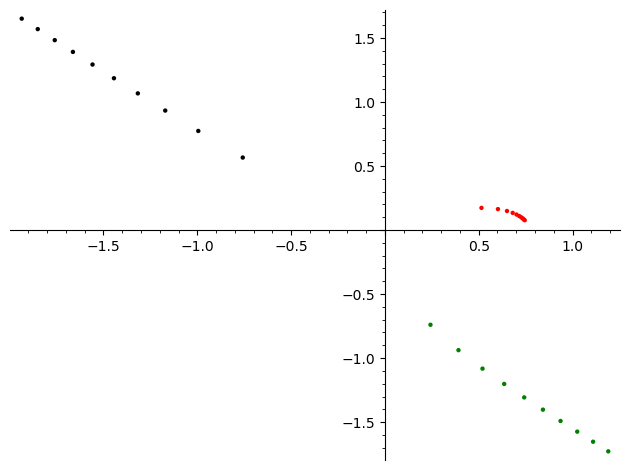

In [495]:
generator

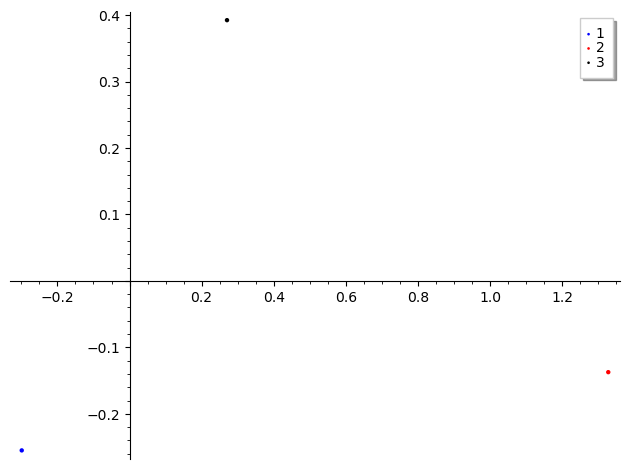

In [498]:
sum([point(key, legend_label= Lambda[key], color=['blue', 'red', 'black'][Lambda[key]-1]) for key in Lambda.keys()])

In [ ]:
bool(-1/20*(10*(I*sqrt(3) + 1)*(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(2/3) + I*sqrt(3) + 3)/(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(1/3) == 1/20*(10*(I*sqrt(3) - 1)*(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(2/3) - I*sqrt(3) + 3)/(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(1/3))

In [ ]:
bool(1/20*(10*(I*sqrt(3) - 1)*(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(2/3) - I*sqrt(3) + 3)/(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(1/3) == 1/20*(10*(I*sqrt(3) - 1)*(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(2/3) - I*sqrt(3) + 3)/(1/30*sqrt(27/10*I*sqrt(3) - 36) - 1/5*I)^(1/3))

In [86]:
A=[1,2,3]
B=A.copy()
B.append(4)
B=A.copy()
print(B)

[1, 2, 3]


In [129]:
bool((-1/8*3^(1/3)*(-sqrt(3))^(1/3)*(I*sqrt(3) + 1) - 1/8*3^(2/3)*(-I*sqrt(3) + 1)/(-sqrt(3))^(1/3) + 1/4*sqrt(3)).full_simplify() == sqrt(3)/2)

True

In [433]:
for key in Lambda.keys():
    print(Lambda[key])
    print(CDF(key))
    print(arg(CDF(key)))
    print('------')

1
1.327756439580034 - 0.13733716420711664*I
-0.10306897760594241
------
2
-0.2990266650155655 - 0.2550816751137592*I
-2.4353364185581574
------
3
0.27030833111218916 + 0.3924188393208758*I
0.9676090693692035
------


In [142]:
Permutation(str((1,2,3)))

[2, 3, 1]

In [153]:
tuple([1,2,3])

(1, 2, 3)

In [117]:
%timeit solve(f_infty==I, x, solution_dict=True)

3.08 ms ± 18.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
%timeit solve(f==I, x, solution_dict=True)

3.82 ms ± 12.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
(f-I).roots()

[(-1/8*(3*sqrt(3) + sqrt(-48*I*sqrt(3) - 64) - 8*I)^(1/3)*(I*sqrt(3) + 1) - 3/8*(-I*sqrt(3) + 1)/(3*sqrt(3) + sqrt(-48*I*sqrt(3) - 64) - 8*I)^(1/3) + 1/4*sqrt(3),
  1),
 (-1/8*(3*sqrt(3) + sqrt(-48*I*sqrt(3) - 64) - 8*I)^(1/3)*(-I*sqrt(3) + 1) - 3/8*(I*sqrt(3) + 1)/(3*sqrt(3) + sqrt(-48*I*sqrt(3) - 64) - 8*I)^(1/3) + 1/4*sqrt(3),
  1),
 (1/4*sqrt(3) + 1/4*(3*sqrt(3) + sqrt(-48*I*sqrt(3) - 64) - 8*I)^(1/3) + 3/4/(3*sqrt(3) + sqrt(-48*I*sqrt(3) - 64) - 8*I)^(1/3),
  1)]

In [128]:
%timeit solve(f==I, x, solution_dict=True)

3.89 ms ± 88.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [130]:
solve(f==0, x, solution_dict=True)

[{x: 3/4*sqrt(3)}, {x: 0}]

In [212]:
Permutation('(1,2)')*Permutation('(2,3)')

[3, 1, 2]

In [374]:
L = []
for i in range(3):
    L.append(i)

for i in L:
    print(i)

0
1
2


In [378]:
arg(1+I)

1/4*pi

In [524]:
generators

{+Infinity: [3, 1, 2], -1/2: [3, 2, 1], 3/2: [1, 3, 2]}

In [526]:
generators[oo]*generators[-1/2]*generators[3/2]

[1, 2, 3]